# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [253]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from scipy.spatial.distance import cdist


Note: I replaced sklearn.mixture.GMM with sklearn.mixture.GaussianMixture, once the latter was deprecatted and will no longer works after version 0.20. Current version is 0.19.2.

Load feature names.

In [254]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [255]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

print(train_data[0],train_labels[0])

(7000, 126) (1124, 126)
(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0.]), 1)


**(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].**

('Explained variance ratio: \n', array([0.16404331, 0.13323479]))
('Cumulative explained variance: \n', array([0.16404331, 0.2972781 ]))
('Explained variance ratio: \n', array([0.16404331, 0.13323479, 0.10173457, 0.07063356, 0.03866646,
       0.03680804, 0.03128239, 0.02733737, 0.0261649 , 0.02230943,
       0.02048173, 0.01868331, 0.01734422, 0.01684361, 0.01518819,
       0.01508618, 0.01429134, 0.01412013, 0.01325045, 0.01146379,
       0.01071066, 0.01065747, 0.01040967, 0.00993699, 0.0090807 ,
       0.00869326, 0.00795617, 0.00775825, 0.0073757 , 0.00700276,
       0.00641233, 0.00614513, 0.00572345, 0.00533629, 0.00525936,
       0.00502674, 0.00499042, 0.00455942, 0.00452784, 0.00439788,
       0.00419489, 0.00397702, 0.00370042, 0.00359528, 0.00338124,
       0.00298987, 0.00272031, 0.00235706, 0.00221397, 0.00204451]))
('Cumulative explained variance: \n', array([0.16404331, 0.2972781 , 0.39901267, 0.46964623, 0.50831269,
       0.54512074, 0.57640313, 0.6037405 , 0.62990541

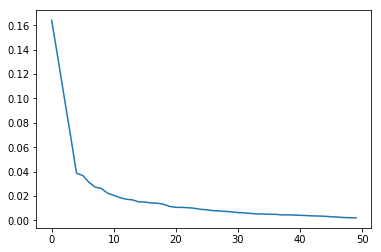

In [256]:
def P1(num_comp, dataset):
    '''
    Simple function to fit a PCA model and report it's explained ratios. It prints the ratios array and 
    plots a chart where we can see the where adding components doesn't add much to the model.
    '''

    pca_mod = PCA(n_components = num_comp)
    pca_mod.fit(dataset)

    print ('Explained variance ratio: \n', pca_mod.explained_variance_ratio_) 
    print ('Cumulative explained variance: \n', np.cumsum(pca_mod.explained_variance_ratio_))
    
    return pca_mod

P1(2, train_data)

chart = P1(50, train_data)
fig = plt.plot(chart.explained_variance_ratio_)


We can see by the chart and the results that when using k up to 4 we have a fast change in how much variance is explained by the components, but after that the gain starts to be marginal.

**(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html**

('Explained variance ratio: \n', array([0.16404331, 0.13323479]))
('Cumulative explained variance: \n', array([0.16404331, 0.2972781 ]))


Text(0.5,1,'Mushrooms PCA Analisys')

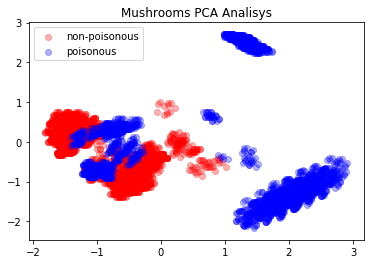

In [257]:
pca_mod = P1(2,train_data).transform(train_data)

colors = ["r","b"]

for color, i, is_poison in zip(colors, [0,1], ["non-poisonous", "poisonous"]):
    plt.scatter(pca_mod[train_labels == i, 0], pca_mod[train_labels == i, 1], color = color, alpha= 0.3, label = is_poison )

plt.legend()
plt.title("Mushrooms PCA Analisys")

**(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.**

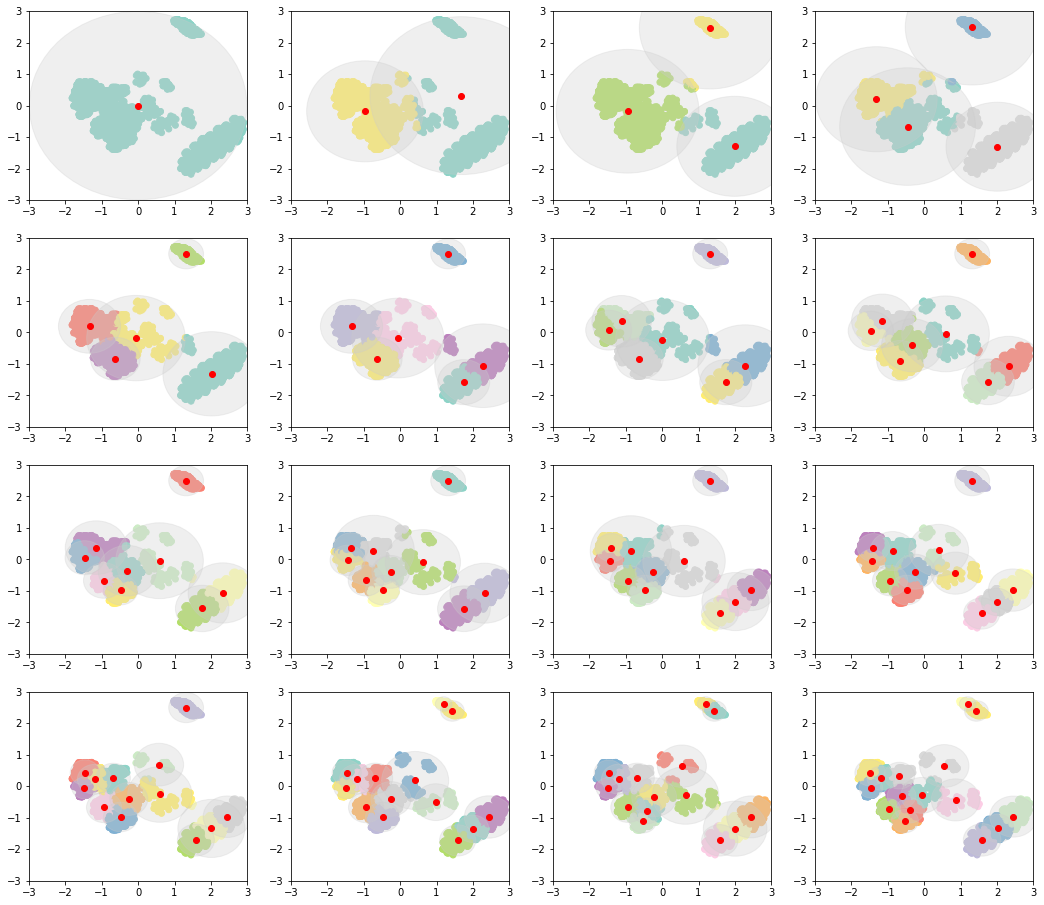

In [258]:
def P3(num_clusters, data_set):
    '''
    function to use the 2D PCA model to fit K-Means clusters. It returns a list containing:
        - number of clusters
        - fitted model
        - predictions of training data
        - tuple containing the center of each cluster and the radius of it.
    '''
    kmeans = KMeans(n_clusters=num_clusters)
    km_mod = kmeans.fit(data_set)
    km_out = kmeans.predict(data_set)
    
    centers = kmeans.cluster_centers_
    radii=[]
    
    for i, center in enumerate(centers):
        radii.append(cdist(data_set[km_out == i], [center]).max())
        
    clusters = zip(centers,radii)
    
    return [num_clusters, km_mod, km_out, clusters]

## Now I want to create a 4x4 plot matrix with 1 to 16 clusters models.

fig = plt.figure(figsize=(18,16)) #initialize a new "squarish" figure

for i in range(1,17): #iterate to generate each subplot: indices 1 to 16.

    output = P3(i, pca_mod) #fit the model using previous function

    ax = fig.add_subplot(4, 4, i)

    ax.scatter(pca_mod[:, 0], pca_mod[:, 1], c=output[2], cmap='Set3') #add the points
    for cluster in output[3]: #iterate through clusters adding 
        ax.plot(cluster[0][0], cluster[0][1],"or") #plot cluster center
        circ = plt.Circle(cluster[0], cluster[1], color='#cccccc', alpha = 0.3) #create a circle around it with r = distance to the fartest point of the cluster.
        ax.add_patch(circ) #add the circle
        ax.set_xlim(-3,3) #adjusting axis
        ax.set_ylim(-3,3)



**(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').**

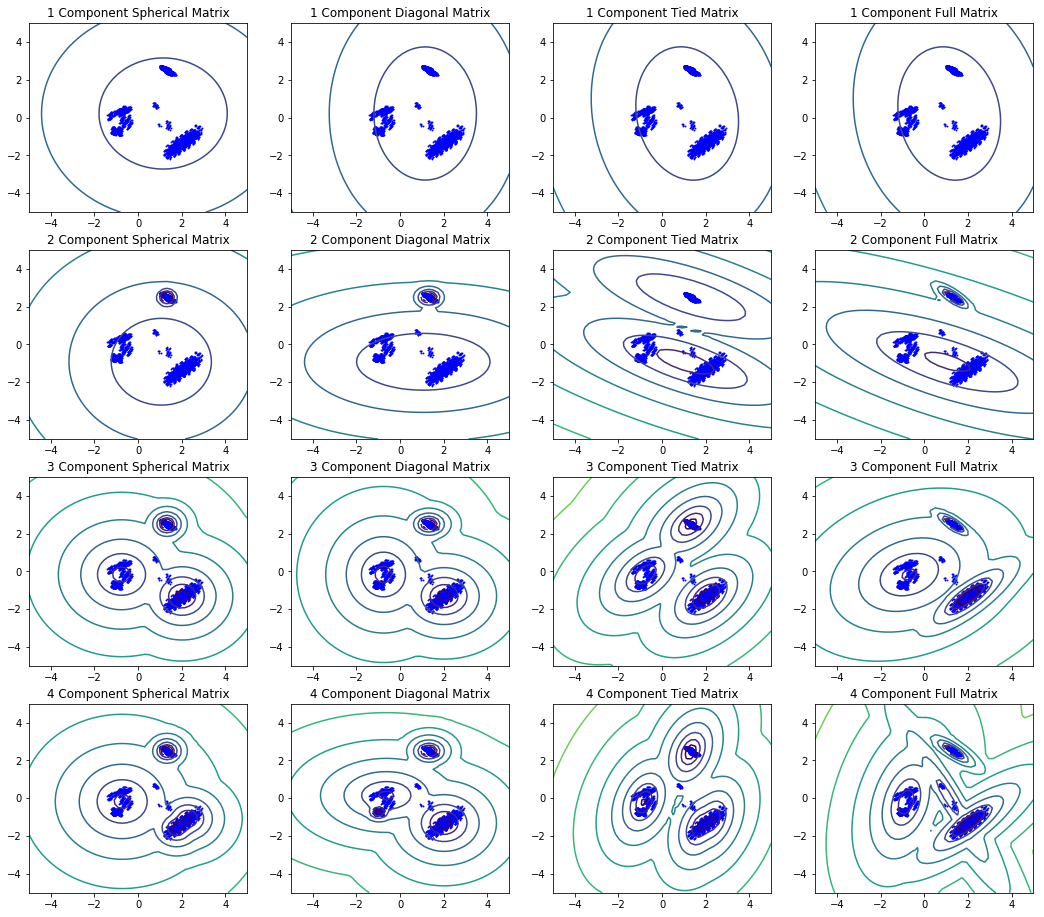

In [263]:
data = pca_mod[train_labels == 1] #filtering the data to use the positive models

mat_types = ['Spherical', 'Diagonal', 'Tied', 'Full'] #matrix typses for printing the results
mat_names = ['spherical', 'diag', 'tied', 'full']#possible matrix types to use in the models.


fig = plt.figure(figsize=(18,16)) #create a "squarish" figure
ax = fig.subplots(nrows=4,ncols=4)

for row in range(4): #iterate through plot rows,
    for col in range(4): #iterate through plot columns
        
        #fit the model. NOte that I used GaussianMixture instead of GMM. See "import" for details.
        gmm_mod = GaussianMixture(n_components = row + 1, covariance_type = mat_names[col])
        gmm_mod.fit(data)
        
        #creating the contours according to the given webpage.
        x = np.linspace(-5, 5)
        y = np.linspace(-5, 5)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -gmm_mod.score_samples(XX)
        Z = Z.reshape(X.shape)
        
        #plotting the chart
        plt.subplot(4,4,(4*row + (col+1)))
        
        #plotting the contours and the points
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
        plt.scatter(data[:, 0], data[:, 1], .8, color = 'b')
        
        #adding the chart title for reference.\
        plt.title(str(row+1) + ' Component ' + mat_types[col] + ' Matrix')


**(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?**

In [271]:
#re-do the model to make sure we are using the right one
pca_mod = PCA(n_components = 2)
pca_mod.fit(train_data)
pca_train = pca_mod.transform(train_data)

#fit the test data as well
pca_test = pca_mod.transform(test_data)

#filter train data using the positive and negative labels for comparing
data_pos = pca_train[train_labels == 1]
data_neg = pca_train[train_labels == 0]

#create the GMM model
gmm_mod = GaussianMixture(n_components = 4, covariance_type = 'full')

#fit positive data
gmm_mod.fit(data_pos)
p_pos = gmm_mod.score_samples(pca_test)

#fit negative data
gmm_mod.fit(data_neg)
p_neg = gmm_mod.score_samples(pca_test)

#checking results
#print('Positive examples scores: ' + str(p_pos))
#print('Negative examples scores: ' + str(p_neg))

used = '' #variable used for printing output

predictions = np.where(p_neg > p_pos,0,1) #if the prob of negative model is higher, use it, else use from positive model

if np.mean(p_pos) > np.mean(p_neg): #used for printing output. Based on average probability for each observation.
    used = 'positive'
else:
    used = 'negative'

acc = np.sum((predictions == test_labels))/float(len(test_labels)) #accuracy calculation: true positives over total.
    
print('Higher accuracy for ' + used + ' labels: ' + str(acc)) #print output

Higher accuracy for positive labels: 0.9501779359430605


Note: I've used GaussianMixture.score_samples() here because it returns the weighted log probabilities for each sample, like GMM.score() used to have.

**(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:**

**( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters**

**You should vary the number of PCA components, the number of GMM components, and the covariance type.**

First some parameters for the test. We saw that with more than 4 principal components we the improvement becomes marginal, which gives us testing range from 1 to 5 components. 
For the GMM components we can calculate the possible range to avoid breaking the constraint of 50 parameters to be up to 25 components when PCA.n_components = 1 and 2 when PCA.n_components = 5.
With that we test our models:

In [272]:
#lists to iterate throught the various models
pca_components = range(1,6)
gmm_components = range(1,26)
mat_names = ['spherical', 'diag', 'tied', 'full']
results = {} #dictinary with the result.


for pca_comp in pca_components:
    for gmm_comp in gmm_components:
        for mat_type in mat_names:
            parameters = (2*pca_comp)*gmm_comp*2
            if parameters < 50: #iterations through all possible combinations where parameters are sums up to 50.

                #fitting the PCA model
                pca_mod = PCA(n_components = pca_comp)
                pca_mod.fit(train_data)
                pca_train = pca_mod.transform(train_data)
                pca_test = pca_mod.transform(test_data)
                
                #filtering positive and negative sets for comparing later. 
                data_pos = pca_train[train_labels == 1]
                data_neg = pca_train[train_labels == 0]
        
                #fitting the GMM model. Code is similar to last question.
                gmm_mod = GaussianMixture(n_components = gmm_comp, covariance_type = mat_type)

                gmm_mod.fit(data_pos)
                p_pos = gmm_mod.score_samples(pca_test)

                gmm_mod.fit(data_neg)
                p_neg = gmm_mod.score_samples(pca_test)

                used = ''

                predictions = np.where(p_neg > p_pos,0,1)

                if np.mean(p_pos) > np.mean(p_neg):
                    used = 'positive'
                else:
                    used = 'negative'

                acc = np.sum((predictions == test_labels))/float(len(test_labels))
                
                #adding to the results dictionary.
                results[acc] = [pca_comp,gmm_comp,mat_type]

                #to check each and every result, uncomment below:
                #print('Model with {0} PCA comp. and {1} GMM comp.: {2:.2f} accuracy with {3} matrix. Total {4} parameters').format(pca_comp, gmm_comp, acc, mat_type, parameters)


In [274]:
#checking the highest score and printing result
champion = results[max(results)]
print('Best case is with {0} PCA components, {1} GMM components and {2} matrix, achieving and accuracy of {3:.2f}% using {4} parameters.').format(champion[0], champion[1], champion[2], (max(results)*100), (2*champion[0])*champion[1]*2)

Best case is with 4 PCA components, 3 GMM components and tied matrix, achieving and accuracy of 96.98% using 48 parameters.


As expected the better result was with 4 PCA components.